In [63]:
# TEXT SENTIMENT ANALYSIS

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 100)

# Load joined dataset
PATH_IN = "../data/interim/sales_joined_cleaned.csv"
df = pd.read_csv(PATH_IN)

# Dates
for col in ["sale_date", "last_purchase_date", "created_at", "timestamp", "date"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

print(df.shape)
df.head()

(8000, 18)


,sale_id,customer_id,product_id,product_name,category,price,quantity,sale_date,total_value,age,gender,region,segment,churn,tenure_months,last_purchase_date,feedback_text,sentiment
0,S000001,CUST01553,P004,Desk,Furniture,12000,2,2020-01-07,24000,40,Female,West,Small Business,1,37,2023-04-04,"Terrible experience, will not buy again.",Negative
1,S000002,CUST00161,P010,Projector,Electronics,45000,2,2023-11-10,90000,50,Female,West,Corporate,0,44,2023-03-02,Excellent customer service.,Positive
2,S000003,CUST00627,P010,Projector,Electronics,45000,4,2022-07-04,163000,33,Male,South,Corporate,0,25,2023-11-04,Product quality could be better.,Neutral
3,S000004,CUST01291,P009,Monitor,Electronics,12000,1,2023-10-18,12000,41,Male,West,Consumer,0,56,2023-08-18,"Delivery was late, not happy.",Positive
4,S000005,CUST01456,P004,Desk,Furniture,12000,4,2023-09-13,48000,60,Female,West,Consumer,0,52,2023-05-14,"Delivery was late, not happy.",Positive


In [64]:
# NLTK VADER sentiment analyzer
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

try:
    _ = nltk.data.find("sentiment/vader_lexicon.zip")
except LookupError:
    nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

In [65]:
# Cleaning + safeguards
def clean_text(s: str) -> str:
    if pd.isna(s): 
        return ""
    s = str(s)
    s = re.sub(r"http\S+|www\.\S+", "", s)                 # removing URLs
    s = re.sub(r"[^A-Za-z0-9\s\.\,\!\?']", " ", s)         # keeping simple chars
    s = re.sub(r"\s+", " ", s).strip()
    return s

# to decide the text column to use
text_col_candidates = ["feedback_text", "comment", "review", "text", "message", "body", "content", "summary"]
text_col = next((c for c in text_col_candidates if c in df.columns), None)

if text_col is None:
    # fallback: auto-detect a text-like object column
    obj_cols = df.select_dtypes(include=["object", "string"]).columns.tolist()
    # drop obvious non-texts
    drop_like = {"id","_id","user","email","phone","order","ticket","sku","product_id","region","city",
                 "sentiment","label","score","rating","stars","polarity","compound","month","date","created","timestamp","sale_date"}
    cand = [c for c in obj_cols if all(k not in c.lower() for k in drop_like)]
    if len(cand):
        # pick the one with the longest average string
        def _avg_len(s):
            try:
                return s.dropna().astype(str).str.len().mean()
            except Exception:
                return 0.0
        text_col = max(cand, key=lambda c: _avg_len(df[c]))
    else:
        text_col = "feedback_text"
        df[text_col] = ""

print("Text column:", text_col)

df["text_clean"] = df[text_col].apply(clean_text)

Text column: feedback_text


In [66]:
# VADER scores + label
vader_scores = df["text_clean"].apply(sia.polarity_scores)
vader_scores = pd.DataFrame(vader_scores.tolist())  # neg, neu, pos, compound
df = pd.concat([df, vader_scores], axis=1)

def to_label(c):
    if c >=  0.05:  return "positive"
    if c <= -0.05:  return "negative"
    return "neutral"

df["sentiment_label"] = df["compound"].apply(to_label)
df[["customer_id" if "customer_id" in df.columns else df.columns[0], text_col, "compound","pos","neu","neg","sentiment_label"]].head(10)

,customer_id,feedback_text,compound,pos,neu,neg,sentiment_label
0,CUST01553,"Terrible experience, will not buy again.",-0.4767,0.000,0.617,0.383,negative
1,CUST00161,Excellent customer service.,0.5719,0.649,0.351,0.000,positive
2,CUST00627,Product quality could be better.,0.4404,0.420,0.580,0.000,positive
3,CUST01291,"Delivery was late, not happy.",-0.4585,0.000,0.572,0.428,negative
4,CUST01456,"Delivery was late, not happy.",-0.4585,0.000,0.572,0.428,negative
5,CUST00634,Product quality could be better.,0.4404,0.420,0.580,0.000,positive
6,CUST01463,Excellent customer service.,0.5719,0.649,0.351,0.000,positive
7,CUST00235,"Terrible experience, will not buy again.",-0.4767,0.000,0.617,0.383,negative
8,CUST01822,Excellent customer service.,0.5719,0.649,0.351,0.000,positive
9,CUST01772,"Delivery was late, not happy.",-0.4585,0.000,0.572,0.428,negative


Overall sentiment distribution (%):


,count,percent
sentiment_label,,
positive,4771,59.64
neutral,816,10.20
negative,2413,30.16


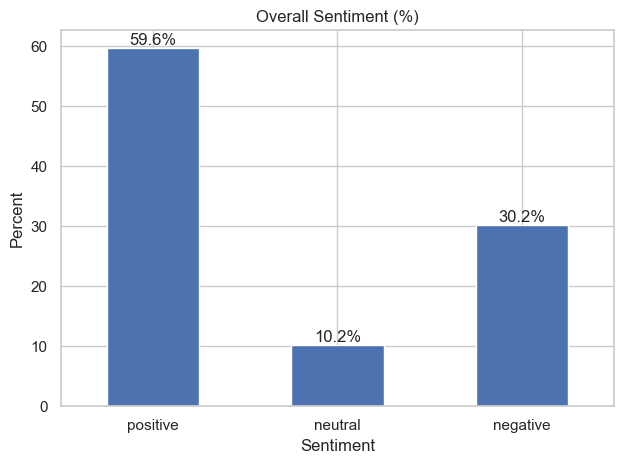

In [67]:
# Overall % distribution
order = ["positive", "neutral", "negative"]
counts = df["sentiment_label"].value_counts().reindex(order, fill_value=0)
perc = (counts / counts.sum() * 100).round(2)
sent_overall = pd.DataFrame({"count": counts, "percent": perc})
print("Overall sentiment distribution (%):")
display(sent_overall)

ax = sent_overall["percent"].plot(kind="bar", rot=0)
ax.set_title("Overall Sentiment (%)")
ax.set_ylabel("Percent")
ax.set_xlabel("Sentiment")
for i, v in enumerate(sent_overall["percent"].values):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha="center")
plt.tight_layout()
plt.show()

Monthly sentiment (%):


sentiment_label,positive,neutral,negative
month,,,
2020-01-01,56.34,16.90,26.76
2020-02-01,54.70,10.50,34.81
2020-03-01,57.89,7.37,34.74
2020-04-01,60.74,11.66,27.61
2020-05-01,55.38,15.05,29.57
2020-06-01,64.71,7.06,28.24
2020-07-01,63.35,6.83,29.81
2020-08-01,63.80,8.59,27.61
2020-09-01,57.54,13.41,29.05


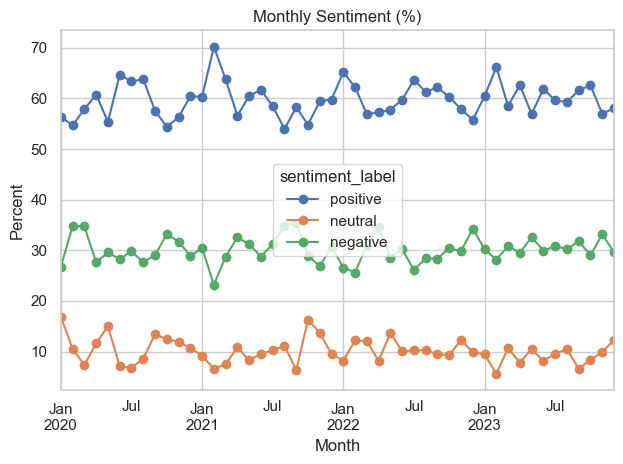

Latest month snapshot (%, and Δ pp):


,positive_%,neutral_%,negative_%,MoM_pos_pp,MoM_neu_pp,MoM_neg_pp,YoY_pos_pp,YoY_neu_pp,YoY_neg_pp
2023-12-01,58.02,12.35,29.63,1.05,2.46,-3.51,2.21,2.46,-4.67


ALERT needed: False  |  negative%=29.63, MoM Δ=-3.51pp

Highest negative-share months:


,neg_percent
month,
2021-09-01,35.44
2021-08-01,34.87
2020-02-01,34.81
2020-03-01,34.74
2022-04-01,34.59
2022-12-01,34.30
2020-10-01,33.16
2023-11-01,33.14
2023-05-01,32.60


In [68]:
# Monthly % breakdown
if "sale_date" in df.columns:
    df["month"] = df["sale_date"].dt.to_period("M").dt.to_timestamp()

elif "created_at" in df.columns:
    df["month"] = df["created_at"].dt.to_period("M").dt.to_timestamp()

elif "timestamp" in df.columns:
    df["month"] = df["timestamp"].dt.to_period("M").dt.to_timestamp()

elif "date" in df.columns:
    df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

# Compute monthly % (only if we have month)
if "month" in df.columns:
    monthly_counts = (
        df.groupby(["month", "sentiment_label"], dropna=False)
          .size()
          .reset_index(name="count")
    )
    monthly_counts["percent"] = (
        monthly_counts["count"]
        / monthly_counts.groupby("month")["count"].transform("sum")
        * 100
    )

    pivot_pct = (
        monthly_counts
          .pivot(index="month", columns="sentiment_label", values="percent")
          .reindex(columns=order)
          .fillna(0)
          .sort_index()
    )

    print("Monthly sentiment (%):")
    display(pivot_pct.round(2))

    pivot_pct.plot(marker="o")
    plt.title("Monthly Sentiment (%)")
    plt.ylabel("Percent")
    plt.xlabel("Month")
    plt.tight_layout()
    plt.show()

    # Snapshot + alert
    latest_month = pivot_pct.index[-1]
    prev_month   = pivot_pct.index[-2] if len(pivot_pct) > 1 else latest_month

    latest = pivot_pct.loc[latest_month]
    prev   = pivot_pct.loc[prev_month]

    yoy = (pivot_pct - pivot_pct.shift(12)).loc[latest_month] if len(pivot_pct) > 12 else pd.Series(index=order, dtype=float)

    snapshot = pd.DataFrame({
        "positive_%": [round(latest["positive"], 2)],
        "neutral_%":  [round(latest["neutral"],  2)],
        "negative_%": [round(latest["negative"], 2)],
        "MoM_pos_pp": [round(latest["positive"] - prev["positive"], 2)],
        "MoM_neu_pp": [round(latest["neutral"]  - prev["neutral"],  2)],
        "MoM_neg_pp": [round(latest["negative"] - prev["negative"], 2)],
        "YoY_pos_pp": [round(yoy["positive"], 2) if "positive" in yoy.index and pd.notna(yoy["positive"]) else np.nan],
        "YoY_neu_pp": [round(yoy["neutral"],  2) if "neutral"  in yoy.index and pd.notna(yoy["neutral"])  else np.nan],
        "YoY_neg_pp": [round(yoy["negative"], 2) if "negative" in yoy.index and pd.notna(yoy["negative"]) else np.nan],
    }, index=[latest_month])

    print("Latest month snapshot (%, and Δ pp):")
    display(snapshot)

    NEG_LEVEL = 33.0
    NEG_MOM_JUMP = 3.0
    neg_alert = (snapshot["negative_%"].iloc[0] >= NEG_LEVEL) or (snapshot["MoM_neg_pp"].iloc[0] >= NEG_MOM_JUMP)
    print(f"ALERT needed: {neg_alert}  |  negative%={snapshot['negative_%'].iloc[0]:.2f}, MoM Δ={snapshot['MoM_neg_pp'].iloc[0]:+.2f}pp")

    # Highest negative-share months
    spikes_neg = pivot_pct["negative"].sort_values(ascending=False).head(10)
    print("\nHighest negative-share months:")
    display(spikes_neg.to_frame("neg_percent").round(2))

In [69]:
# Per-customer sentiment features: latest + shares + aggregates

# Latest sentiment per customer (by most recent sale_date)
id_col = "customer_id" if "customer_id" in df.columns else df.columns[0]
date_for_latest = "sale_date" if "sale_date" in df.columns else ("created_at" if "created_at" in df.columns else None)

if date_for_latest is not None:
    latest = (df.sort_values(date_for_latest)
                .groupby(id_col, as_index=False)
                .tail(1)[[id_col, "compound","pos","neu","neg","sentiment_label"]]
                .rename(columns={
                    "compound":"compound_last",
                    "pos":"pos_last", "neu":"neu_last", "neg":"neg_last",
                    "sentiment_label":"sentiment_last"
                }))
else:
    latest = df.groupby(id_col, as_index=False)[["compound","pos","neu","neg"]].last()
    latest["sentiment_last"] = df.groupby(id_col)["sentiment_label"].last().values

# Shares of sentiment classes per customer
shares = (df.groupby(id_col)["sentiment_label"]
            .value_counts(normalize=True)
            .rename("share")
            .reset_index()
            .pivot(index=id_col, columns="sentiment_label", values="share")
            .fillna(0.0))
shares.columns = [f"share_{c.lower()}" for c in shares.columns]  # share_negative/share_neutral/share_positive

# Aggregates per customer (include columns only if present)
agg_dict = {
    "compound": ["mean","median","max","min"]
}
if text_col in df.columns:
    agg_dict[text_col] = ["count"]
if "churn" in df.columns:
    agg_dict["churn"] = ["max"]
if "region" in df.columns:
    agg_dict["region"] = ["last"]
if "tenure_months" in df.columns:
    agg_dict["tenure_months"] = ["last"]

agg_raw = df.groupby(id_col).agg(agg_dict)
agg_raw.columns = ["_".join([c for c in col if c]).strip("_") for col in agg_raw.columns.to_flat_index()]
agg = agg_raw.reset_index().rename(columns={f"{text_col}_count":"n_feedback"} if f"{text_col}_count" in agg_raw.columns else {})

cust_sent = (agg
             .merge(shares, on=id_col, how="left")
             .merge(latest, on=id_col, how="left"))

for c in ["share_negative","share_neutral","share_positive"]:
    if c in cust_sent.columns:
        cust_sent[c] = cust_sent[c].fillna(0.0)

print(cust_sent.shape)
cust_sent.head()

(1967, 17)


,customer_id,compound_mean,compound_median,compound_max,compound_min,n_feedback,churn_max,region_last,tenure_months_last,share_negative,share_neutral,share_positive,compound_last,pos_last,neu_last,neg_last,sentiment_last
0,CUST00001,0.285950,0.28595,0.5719,0.0000,2,0,South,50,0.00,0.5,0.50,0.5719,0.649,0.351,0.000,positive
1,CUST00002,0.051050,-0.00905,0.6808,-0.4585,4,1,East,37,0.50,0.0,0.50,-0.4585,0.000,0.572,0.428,negative
2,CUST00003,0.276875,0.50615,0.5719,-0.4767,4,0,North,18,0.25,0.0,0.75,0.5719,0.649,0.351,0.000,positive
3,CUST00004,0.308720,0.42010,0.5719,-0.3089,5,0,East,3,0.20,0.0,0.80,0.4201,0.482,0.518,0.000,positive
4,CUST00005,-0.476700,-0.47670,-0.4767,-0.4767,1,0,West,45,1.00,0.0,0.00,-0.4767,0.000,0.617,0.383,negative


In [70]:
# Saving the text analysis model (simple pickle of the analyzer)
import pickle

with open("../models/text_sentiment_model.pkl", "wb") as f:
    pickle.dump(sia, f)

print("Saved: ../models/text_sentiment_model.pkl")

Saved: ../models/text_sentiment_model.pkl


In [71]:
# Loading & doing the smoke test
import pickle

with open("../models/text_sentiment_model.pkl", "rb") as f:
    loaded_sia = pickle.load(f)

probe = pd.Series(["loved the support", "terrible delay", "not good at all", "absolutely fantastic"])
probe_clean = probe.apply(clean_text)
probs = probe_clean.apply(loaded_sia.polarity_scores)
probs = pd.DataFrame(probs.tolist())
probs["label"] = probs["compound"].apply(lambda c: "positive" if c>=0.05 else ("negative" if c<=-0.05 else "neutral"))
probs.index = probe
probs

,neg,neu,pos,compound,label
loved the support,0.000,0.132,0.868,0.7650,positive
terrible delay,1.000,0.000,0.000,-0.6597,negative
not good at all,0.445,0.555,0.000,-0.3412,negative
absolutely fantastic,0.000,0.204,0.796,0.5984,positive
